In [72]:
!pip install wget
!pip install wandb
!pip install xtarfile

In [73]:

import os
from os.path import exists
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random 
import numpy as np
import keras
import tensorflow as tf
import xtarfile as tarfile
import csv
from keras import Model
from keras.layers import Layer
import keras.backend as K

### Configuration

In [74]:
START_TOKEN="0"
END_TOKEN="1"

In [75]:

class Dataset:
    
    def downloadDataSet(self):
      cwd = os.getcwd()
     
      file_exists = exists('./dakshina_dataset_v1.0.tar')
      if(file_exists==False):
        print('downloading....')
        os.system('curl -SL https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar > dakshina_dataset_v1.0.tar')
        print('download Complete')
      extract_exists = exists('./dakshina_dataset_v1.0/')   
      if(extract_exists==False): 
        print('Extracting..') 
        with tarfile.open('dakshina_dataset_v1.0.tar', 'r') as archive:
            archive.extractall()
        print('Complete')

      print('You are all set')

    def readData(self,dir,start_token="0",end_token="1"):
      # Vectorize the data.
      input_texts=list()
      target_texts=list()
      original_input_texts=list()
      original_target_texts=list()
      input_characters = set()
      target_characters = set()
      with open(dir, "r", encoding="utf-8") as f:
        lines = f.read().split("\n")
      
      for line in lines:
          ln = line.split("\t")
          if(len(ln)==3):
            target_text=ln[0].strip()  
            input_text=ln[1].strip()
            original_input_texts.append(input_text)
            original_target_texts.append(target_text)
            input_text+=end_token
            target_text = start_token + target_text + end_token
            input_texts.append(input_text)
            target_texts.append(target_text)
            for char in input_text:
              if char not in input_characters:
                input_characters.add(char)
            for char in target_text:
             if char not in target_characters:
               target_characters.add(char)
      input_characters = sorted(list(input_characters))
      target_characters = sorted(list(target_characters))
      return original_input_texts,original_target_texts,input_texts,target_texts,input_characters,target_characters


   

    #def encode_decode_characters(self,train_input, train_target, val_input=[], val_target=[],start_token="\t",end_token="\n"):
    def encode_decode_characters(self,train_input, train_target,start_token="0",end_token="1"):
        # Returns the encoding for characters to integer (as a dictionary) and decoding for integers to characters (as a list) for in
        BLANK_CHAR=' '
        # Encoding and decoding of input vocabulary
        input_char_enc = {}
        input_char_dec = []
        max_encoder_seq_length = 1
        tmplist=[]
        for i in train_input:
            tmplist.append(i)
        """for i in val_input:
            tmplist.append(i)"""
        for string in tmplist:
            max_encoder_seq_length = max(max_encoder_seq_length, len(string))
            for char in string:
                if char not in input_char_enc:
                    input_char_enc[char] = len(input_char_dec)
                    input_char_dec.append(char)
        """if BLANK_CHAR not in input_char_enc:
            input_char_enc[BLANK_CHAR] = len(input_char_dec)
            input_char_dec.append(BLANK_CHAR)
"""
        # Encoding and decoding of target vocabulary
        target_char_enc = {}
        target_char_dec = []
        #target_char_enc[start_token] = len(target_char_dec)
        #target_char_dec.append(start_token)
        max_decoder_seq_length = 1
        for string in train_target :#+ val_target:
            max_decoder_seq_length = max(max_decoder_seq_length, len(string)+2)
            for char in string:
                if char not in target_char_enc:
                    target_char_enc[char] = len(target_char_dec)
                    target_char_dec.append(char)
        #target_char_enc[end_token] = len(target_char_dec)
        #target_char_dec.append(end_token)
        """if ' ' not in target_char_enc:
            target_char_enc[BLANK_CHAR] = len(target_char_dec)
            target_char_dec.append(BLANK_CHAR)"""

        """print("Number of training samples:", len(train_input))
        print("Number of validation samples:", len(val_input))
        print("Number of unique input tokens:", len(input_char_dec))
        print("Number of unique output tokens:", len(target_char_dec))
        print("Max sequence length for inputs:", max_encoder_seq_length)
        print("Max sequence length for outputs:", max_decoder_seq_length)"""

        return input_char_enc, input_char_dec, target_char_enc, target_char_dec, max_encoder_seq_length, max_decoder_seq_length
    def preprocessing(self,input_char_enc, input_char_dec, target_char_enc, target_char_dec,max_encoder_seq_length,max_decoder_seq_length,input_texts,target_texts,start_token="0",end_token="1"):
        encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length), dtype="float32")
        decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length), dtype="float32")
        decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, len(target_char_dec)), dtype="float32")
        for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
            for t, char in enumerate(input_text):
                encoder_input_data[i, t] =input_char_enc[char]
            #encoder_input_data[i, t + 1 :] = input_char_enc[start_token]

            for t, char in enumerate(target_text):
                # decoder_target_data is ahead of decoder_input_data by one timestep
                decoder_input_data[i, t, ] = target_char_enc[char]
                if t > 0:
                    # decoder_target_data will be ahead by one timestep
                    # and will not include the start character.
                    decoder_target_data[i, t - 1, target_char_enc[char]] = 1.0
            decoder_input_data[i, t + 1 :] = target_char_enc[end_token]
            decoder_target_data[i, t:, target_char_enc[end_token]] = 1.0
        return encoder_input_data,decoder_input_data,decoder_target_data


       
   

### Sequence to sequence With Attention

In [93]:
from keras.layers import Layer
import keras.backend as K

class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
    Credits to Tensorflow.org and  https://github.com/thushv89/attention_keras/
    """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='glorot_uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='glorot_uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='glorot_uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            # (batch_size, decoder_timesteps, decoder_hid_layer_size)
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            # (batch_size, decoder_timesteps, encoder_timesteps)
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [95]:
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils.vis_utils import plot_model
class seqTOseq:
  def parameters(self,input_char_dec,target_char_dec,\
                 num_of_encoders=1,\
                 num_of_decoders=1,\
                 latent_dim=64,\
                 inp_emb_size=64,\
                 cell_type="lstm",\
                 cell_activation="tanh",\
                 optimizer="adam",\
                 dropout=0):
      self.num_encoder_tokens=len(input_char_dec)
      self.num_decoder_tokens=len(target_char_dec)
      self.latent_dim=latent_dim
      self.cell_type=cell_type
      self.optimizer=optimizer
      self.num_of_encoders=num_of_encoders
      self.num_of_decoders=num_of_decoders
      self.dropout=dropout
      self.inp_emb_size=inp_emb_size
      self.cell_activation=cell_activation
  def model(self):
      if(self.cell_type=="rnn"):
         cell=keras.layers.SimpleRNN
      if(self.cell_type=="lstm"):
        cell=keras.layers.LSTM     
      if(self.cell_type=="gru"):
         cell=keras.layers.GRU
      # Define an input sequence and process it.
      
      encoder_input = keras.layers.Input(shape=(None,), name="input_1")
      encoder_inp_emb = keras.layers.Embedding(self.num_encoder_tokens, self.inp_emb_size, name="embedding_1")(encoder_input)
      encoder =cell(self.latent_dim, return_state=True,\
                    return_sequences=True,\
                    activation=self.cell_activation,\
                    name="encoder_1",\
                    dropout=self.dropout)        
    
      encoder_outputs, *encoder_states = encoder(encoder_inp_emb)
      for i in range(1,self.num_of_encoders):
        encoder_outputs, *encoder_states = cell(self.latent_dim,\
                                       return_state=True,\
                                       return_sequences=True,\
                                       activation=self.cell_activation,\
                                       dropout=self.dropout,\
                                       name="encoder_"+str(i+1))(
                                                        encoder_outputs,initial_state=encoder_states
                                                 )
      # Set up the decoder, using `encoder_states` as initial state.
      decoder_inputs = keras.Input(shape=(None,), name="input_2")
      #input embedding 
      decoder_inp_emb = keras.layers.Embedding(self.num_decoder_tokens, self.inp_emb_size, name="embedding_2")(decoder_inputs)
      decoder=cell(self.latent_dim ,return_sequences=True,\
                   return_state=True,\
                   name="decoder_1",\
                   activation=self.cell_activation,\
                   dropout=self.dropout)
      decoder_outputs, *decode_states=decoder(decoder_inp_emb, initial_state=encoder_states)
      
      for i in range(1,self.num_of_decoders):
        decoder_outputs, *decode_states = cell(self.latent_dim,\
                                       return_state=True,\
                                       return_sequences=True,\
                                       activation=self.cell_activation,\
                                       dropout=self.dropout,\
                                       name="decoder_"+str(i+1))(
                                                        decoder_outputs,initial_state=encoder_states)
     
      attn_out, attn_scores = AttentionLayer(name='attention_1')([encoder_outputs, decoder_outputs])        # Bahdanau Attention    
      dense_concat_input = keras.layers.Concatenate(axis=-1, name='concat_layer_1')([decoder_outputs  ,attn_out])                            
      decoder_dense = keras.layers.Dense(self.num_decoder_tokens, activation="softmax")
      decoder_outputs = decoder_dense(dense_concat_input)
      # Define the model that will turn
      # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
      model = keras.Model([encoder_input, decoder_inputs], decoder_outputs)
      model.compile(optimizer=self.optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
      return model
  def modelSummary(self,model):
      plot_model(model, to_file='encoder_model.png', show_shapes=True)
      f = plt.figure()
      f.set_figwidth(20)
      f.set_figheight(20)
      plt.imshow(mpimg.imread('encoder_model.png'))
      plt.axis('off')
 

  

### Read data from dataset

In [78]:
ds=Dataset()
ds.downloadDataSet()
language='hi'
train_dir='./dakshina_dataset_v1.0/'+language+'/lexicons/'+language+'.translit.sampled.train.tsv'
val_dir='./dakshina_dataset_v1.0/'+language+'/lexicons/'+language+'.translit.sampled.dev.tsv'
test_dir='./dakshina_dataset_v1.0/'+language+'/lexicons/'+language+'.translit.sampled.test.tsv'


You are all set


### Preprocessing data

In [79]:
train_original_input_texts,train_original_target_texts,train_ip_txt,train_op_txt,train_ip_chr,train_op_chr=ds.readData(train_dir)
val_original_input_texts,val_original_target_texts,val_ip_txt,val_op_txt,val_ip_chr,val_op_chr=ds.readData(val_dir)
test_original_input_texts,test_original_target_texts,test_ip_txt,test_op_txt,test_ip_chr,test_op_chr=ds.readData(test_dir)

In [80]:
"""input_char_enc, input_char_dec,\
 target_char_enc,\
target_char_dec,\
max_encoder_seq_length,\
max_decoder_seq_length\
=ds.encode_decode_characters(train_ip_txt, train_op_txt, val_ip_txt, val_op_txt)"""

input_char_enc, input_char_dec,\
target_char_enc,\
target_char_dec,\
max_encoder_seq_length,\
max_decoder_seq_length\
=ds.encode_decode_characters(train_ip_txt, train_op_txt)

##### Assigning training, validation and test encoder input, decoder input, decoder output

In [81]:

train_enc_input, train_dec_input, train_dec_target\
= ds.preprocessing(input_char_enc, input_char_dec, target_char_enc, target_char_dec,max_encoder_seq_length,max_decoder_seq_length,train_ip_txt, train_op_txt)



In [82]:
val_enc_input, val_dec_input, val_dec_target = \
ds.preprocessing(input_char_enc, input_char_dec, target_char_enc, target_char_dec,\
                 max_encoder_seq_length,max_decoder_seq_length,val_ip_txt, val_op_txt)


test_enc_input, test_dec_input, test_dec_target =\
 ds.preprocessing(input_char_enc, input_char_dec, target_char_enc, target_char_dec,max_encoder_seq_length,max_decoder_seq_length\
                  ,test_ip_txt, test_op_txt)


In [143]:

def wordlevelAccurecy(model,target_char_enc,test_ip_txt,test_original_input_texts,test_original_target_texts):
    key_list = list(target_char_enc.keys())
    val_list = list(target_char_enc.values())
    predicted_data=model.predict([test_enc_input, test_dec_input ])
    targetpredicted=[]
    itr=0
    for data in predicted_data:
      wordip=test_ip_txt[itr]
      itr+=1
      wordop=""
      for i in data:

        index=np.argmax(i)
        position = val_list.index(index)
        wordop+=key_list[position]

      #wordop=wordop.replace('\t', '')
      #wordop=wordop.replace('\n', '')
      wordop=wordop.replace('0', '')
      wordop=wordop.replace('1', '')
      #wordop=wordop.replace(' ', '')
      targetpredicted.append(wordop)
      count=0
      countTot=0
    for i in range(len(targetpredicted)):
      countTot+=1
      if(test_original_target_texts[i]==targetpredicted[i]):
          count+=1
    print("word level accurecy: "+str (count/countTot))

    return test_ip_txt,test_original_target_texts,targetpredicted
    """for i in range(len(targetpredicted)):
    print(test_original_input_texts[i]+"   "+test_original_target_texts[i]+"  "+targetpredicted[i])"""



### Call the model

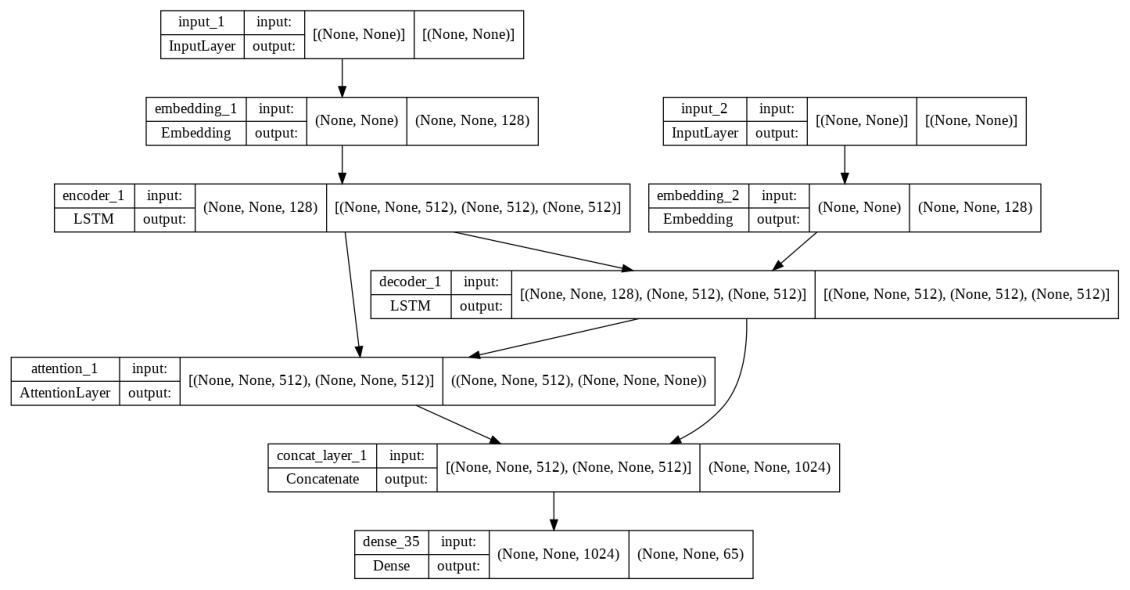

In [96]:
batch_size = 32  # Batch size for training.
epochs = 15  # Number of epochs to train for.
seq=seqTOseq()
seq.parameters(input_char_dec=input_char_dec,\
               target_char_dec=target_char_dec,\
               num_of_encoders=1,\
               num_of_decoders=1,
               latent_dim=512,\
               inp_emb_size=128,\
               cell_type="lstm",\
               cell_activation="tanh",\
               optimizer="adam",\
               dropout=.4)

model=seq.model()
seq.modelSummary(model)

In [97]:
class CustomCallback(keras.callbacks.Callback):
    def __init__(self, model):
        self.model = model
       
    def on_epoch_end(self, epoch, logs={}):
        key_list = list(target_char_enc.keys())
        val_list = list(target_char_enc.values())
        predicted_data=self.model.predict([val_enc_input, val_dec_input ])
        targetpredicted=[]
        itr=0
        for data in predicted_data:
          wordip=test_ip_txt[itr]
          itr+=1
          wordop=""
          for i in data:
          
            index=np.argmax(i)
            position = val_list.index(index)
            wordop+=key_list[position]

          #wordop=wordop.replace('\t', '')
          #wordop=wordop.replace('\n', '')
          wordop=wordop.replace('0', '')
          wordop=wordop.replace('1', '')
          #wordop=wordop.replace(' ', '')
          targetpredicted.append(wordop)
          count=0
          countTot=0
        for i in range(len(targetpredicted)):
          countTot+=1
          if(val_original_target_texts[i]==targetpredicted[i]):
              count+=1
        print(" word level accurecy: "+str (count/countTot))
        

#### Train the model

In [99]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5,restore_best_weights=True)
model.fit(
    [train_enc_input, train_dec_input],
    train_dec_target,
    batch_size=batch_size,
    epochs=15,
   validation_data=([val_enc_input, val_dec_input ] ,val_dec_target),
   callbacks=[earlystop,CustomCallback(model)]
)


Epoch 1/15
1382/1382 [==============================] - 112s 81ms/step - loss: 0.1838 - accuracy: 0.9417 - val_loss: 0.1461 - val_accuracy: 0.9532
Epoch 2/15
1382/1382 [==============================] - 111s 81ms/step - loss: 0.1325 - accuracy: 0.9571 - val_loss: 0.1260 - val_accuracy: 0.9595
Epoch 3/15
1382/1382 [==============================] - 112s 81ms/step - loss: 0.1094 - accuracy: 0.9643 - val_loss: 0.1232 - val_accuracy: 0.9612
Epoch 4/15
1382/1382 [==============================] - 111s 80ms/step - loss: 0.0922 - accuracy: 0.9698 - val_loss: 0.1185 - val_accuracy: 0.9615
Epoch 5/15
1382/1382 [==============================] - 112s 81ms/step - loss: 0.0782 - accuracy: 0.9743 - val_loss: 0.1203 - val_accuracy: 0.9630
Epoch 6/15
1382/1382 [==============================] - 111s 81ms/step - loss: 0.0665 - accuracy: 0.9782 - val_loss: 0.1225 - val_accuracy: 0.9634
Epoch 7/15
1382/1382 [==============================] - 111s 81ms/step - loss: 0.0571 - accuracy: 0.9812 - val_loss: 0

In [144]:
inputseq,outputseq,predseq=wordlevelAccurecy(model,target_char_enc,test_ip_txt,test_original_input_texts,test_original_target_texts)

word level accurecy: 0.4055975122167925


In [101]:
model.save("s2s")

INFO:tensorflow:Assets written to: s2s/assets


INFO:tensorflow:Assets written to: s2s/assets


In [102]:
model = keras.models.load_model("s2s")


In [90]:
"""

model1 = Model(inputs=model1.input,
              outputs=[ model1.get_layer('attention_1').output])"""

"\n\nmodel1 = Model(inputs=model1.input,\n              outputs=[ model1.get_layer('attention_1').output])"

In [91]:
"""op= model.predict([test_enc_input, test_dec_input ])
"""

'op= model.predict([test_enc_input, test_dec_input ])\n'

In [117]:

decoder_model=keras.Model([model.input[0],model.input[1]],model.get_layer('attention_1').output  )

op1,op2= decoder_model.predict([test_enc_input, test_dec_input ])

In [125]:
class CharVal(object):
    def __init__(self, char, val):
        self.char = char
        self.val = val

    def __str__(self):
        return self.char

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
def color_charvals(s):
    r = 255-int(s.val*255)
    color = rgb_to_hex((255, r, r))
    return 'background-color: %s' % color
# if you are using batches the outputs will be in batches
# get exact attentions of chars
an_attention_output = op2[0][-len(target_char_dec):]


In [126]:
an_attention_output.shape

(23, 21)

In [127]:

# before the prediction i supposed you tokenized text
# you need to match each char and attention
char_vals = [CharVal(c, v) for c, v in zip(test_enc_input, an_attention_output)]
fontdict = {'fontsize': 14}






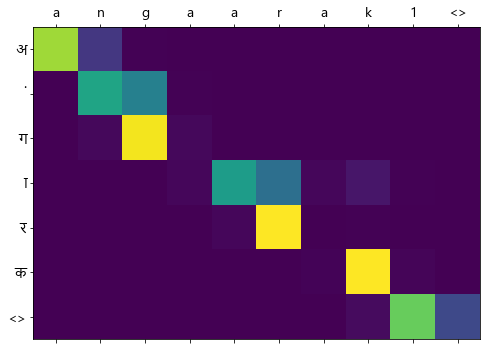

In [179]:
import warnings
warnings.filterwarnings('ignore')
sequence=inputseq[8]
predicted_sequence=predseq[8]
sequence=[char for char in sequence]
sequence.append("<>")

predicted_sequence=[char for char in predicted_sequence]
predicted_sequence.append("<>")
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(op2[8][: len(predicted_sequence),:len(sequence )], cmap='viridis')

import matplotlib.ticker as mticker
from matplotlib.font_manager import FontProperties
hindi_font = FontProperties(fname = 'Nirmala.ttf')
fontdict = {'fontsize': 14}
ax.set_xticklabels([''] + sequence, fontdict=fontdict,fontproperties=hindi_font)
ax.set_yticklabels([''] + predicted_sequence, fontdict=fontdict,fontproperties=hindi_font)

ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mticker.MultipleLocator(1))

plt.show()